In [285]:
# imports and global variables
import pandas as pd
import requests
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import bs4 as bs
import datetime

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from bs4 import BeautifulSoup
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from datetime import timedelta

# AlphaVantage API key
av_api_key = 'JTX5IDF3J02FD6NW'

## Data Collection and Pipeline

In [2]:
def get_url(url):
    """ simple function to access the url
    gets the html data from the given url
    
    Args:
        url (String): the url to request data from
        
    Returns:
        html_str (String): the html response from the url
    """
    # Get response from request url
    response = requests.get(url)
    
    # Return html string
    html_str = response.text
    return html_str

url=f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&interval=5min&symbol=IBM&apikey={av_api_key}'
#get_url(url)    

In [270]:
def construct_and_get_query(func, feats):
    '''Given a dict of desired features and the function, builds a query
    to access the AlphaVantage API to get the html data
    
    Args:
        func (string): the desired function of the query
        feats (dict): a dict of the desired features and values
        
    Returns:
        html_str (string): the html response from the url
    '''
    # Base url for every query
    url = f'https://www.alphavantage.co/query?function={func}'
    
    # Add every feature and value to query
    for feat, value in feats.items():
        url += f'&{feat}={value}'
    
    # Add API key
    url += f'&apikey={av_api_key}'

    # Get the html data from the url
    return get_url(url)

feats = {'symbol': 'IBM'}
ibm_html = construct_and_get_query('overview', feats)
ibm_html

'{\n    "Symbol": "IBM",\n    "AssetType": "Common Stock",\n    "Name": "International Business Machines Corporation",\n    "Description": "International Business Machines Corporation provides integrated solutions and services worldwide. Its Cloud & Cognitive Software segment offers software for vertical and domain-specific solutions in health, financial services, supply chain, and asset management, weather, and security software and services application areas; and customer information control system and storage, and analytics and integration software solutions to support client mission critical on-premise workloads in banking, airline, and retail industries. It also offers middleware and data platform software, including Red Hat that enables the operation of clients\' hybrid multi-cloud environments; and Cloud Paks, WebSphere distributed, and analytics platform software, such as DB2 distributed, information integration, and enterprise content management, as well as IoT, Blockchain and

In [4]:
def get_html(url):
    return json.loads(requests.get(url).text)

url=f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&interval=5min&symbol=IBM&apikey={av_api_key}'
#get_html(url)

In [5]:
def clean_company_series(html_str):
    """ takes in a string of html data containing a company's overview, 
    converts it into a BeautifulSoup object
    and cleans and parses its useful data into a dataframe
    
    Args:
        html_str (String): the html string containing company html data
        
    Returns:
        company_series (pd.Series): Series of cleaned stock data
    """
    # Initialize dictionary to place into series
    feat_dict = {}
    
    # Split the string using nextline and remove start and end curly braces
    feats = html_str[1:-1].split('\n')
    
    # Remove the two empty elements from the split
    for feat in feats[1:-1]:
        # Remove leading and trailing whitespace, quotes, and split by the first colon
        key_value = feat.strip().replace('"', '').split(':', 1)
        
        # Add the feature and specified value to the dictionary. Remove the trailing comma.
        # Some values have commas in it, but will be removed later anyway
        feat_dict[key_value[0]] = key_value[1].strip().replace(',', '')
        
    # Build the series
    company_series = pd.Series(feat_dict)
    return company_series
    
#df_ibm = clean_company_series(ibm_html)
#df_ibm.head()

In [6]:
def create_company_table(company_ids):
    """ Takes in a list of company tickers to access the api and cleans the data 
    to build a table containing the company overview data.
    
    Args:
        company_ids (list): list of company tickers
        
    Returns:
        df_company (pd.DataFrame): the dataframe containing the company overview data
    """
    # Grab the html strings for each company ticker
    #company_htmls = [construct_and_get_query('OVERVIEW', {'symbol': id}) for id in company_ids]

    # Create the dataframe
    df_company = pd.DataFrame()
    
    indicators = ['SMA', 'EMA', 'MACD', 'STOCH', 'RSI', 'ADX', 'CCI', 'AROON', 'BBANDS', 'OBV', 'ATR', 'ROC']
        
    # Clean each html_string and append the resulting series into the dataframe
    for id in company_ids:
        company_string = construct_and_get_query('OVERVIEW', {'symbol': id})
        company_series = clean_company_series(company_string)
        #ti_series = pd.Series(avg_tech_ind(get_tech_ind(id, indicators)))
        
        #full_series = company_series.append(ti_series)
        df_company = df_company.append(company_series, ignore_index = True)
    
    # Update the index
    df_company = df_company.set_index('Symbol')
    
    # Columns with little to no helpful information
    columns_to_drop = ['Address', 'Description']
    df_company.drop(columns_to_drop, inplace=True, axis=1)

    return df_company.reset_index()

In [ ]:
df_ibm = create_company_table(['ibm'])
df_ibm

In [ ]:
# List of S&P 500 companies
df_snp500 = pd.read_csv('constituents_csv.csv')

# Grab the tickers
snp500_tickers = df_snp500.iloc[:, :-2].values[:5].flatten()

# Build the table
df_snp500 = create_company_table(snp500_tickers)
df_snp500

In [7]:
def get_tech_ind(ticker, indicators):
    '''
    '''
    time.sleep(60)
    ti_dict = {}
    i = 0
    for indicator in indicators:
        if i == 5:
            time.sleep(60)
            i = 0
        url = f'https://www.alphavantage.co/query?function={indicator}&symbol={ticker}&interval=daily&time_period=7&series_type=close&apikey={av_api_key}&datatype=json'
        ti_dict[indicator] = json.loads(requests.get(url).text)
        i += 1
        
    return ti_dict    

In [ ]:
indicators = ['SMA', 'EMA', 'MACD', 'STOCH', 'RSI', 'ADX', 'CCI', 'AROON', 'BBANDS', 'ADX', 'OBV', 'ATR', 'ROC']
indicators = ['RSI']
aapl_ti = get_tech_ind('IBM', indicators)

In [8]:
def avg_tech_ind(ti_dict):
    '''
    '''
    ti_avg_dict = {}
    
    for key in ti_dict:
        # Get indicator values
        values = ti_dict[key][f'Technical Analysis: {key}']
        
        i = 0
        for day in values:
            # initialize the keys
            if i == 0:
                for ind in values[day]:
                    ti_avg_dict[ind] = 0
            
            # calculate for 30 days
            if i > 31:
                # average
                for ind in values[day]:
                    ti_avg_dict[ind] /= 30
                break

            # aggregate
            for ind in values[day]:
                #print(day)
                #print(ind)
                ti_avg_dict[ind] += float(values[day][ind])

            i += 1
                
    return ti_avg_dict

In [ ]:
avg_tech_ind(aapl_ti)

In [ ]:
#Obtain list of S&100 companies from wikipedia
resp = requests.get("https://en.wikipedia.org/wiki/S%26P_100")
convert_soup = bs.BeautifulSoup(resp.text, 'lxml')
table = convert_soup.find('table',{'class':'wikitable sortable'})

tickers = []

for rows in table.findAll('tr')[1:]:
    ticker = rows.findAll('td')[0].text.strip()
    tickers.append(ticker)
    
tickers

In [ ]:
snp100.to_csv('snp100_data.csv')

In [ ]:
# Full list of snp_500 companies 
df_snp500_full = pd.read_csv('constituents_csv.csv')

def create_fulldf(start, iterations):
    dataframes = []
    for i in range(start, start + iterations):
        # Grab the tickers
        print(i)
        snp500_tickers = df_snp500_full.iloc[:, :-2].values[(i*5):((i+1)*5)].flatten()
        x = create_company_table(snp500_tickers)
        dataframes.append(x)
        print(x)
        time.sleep(60)
    df_final = pd.concat(dataframes)
    if 'Error Message' in df_final.columns:
        df_final.drop('Error Message', axis=1).dropna(how='all', inplace=True)
    return df_final
        
# Build the table
df_snp500_1 = create_fulldf(0, 10)
df_snp500_1

## Random Forest Regression and Feature Importance

In [73]:
snp100_p1 = pd.read_csv('snp100_data.csv')
snp100_p2 = pd.read_csv('snp100_ti_14_day_avg.csv')

In [74]:
snp100_p2.rename(columns={'Unnamed: 0': 'Symbol'}, inplace=True)
snp100_p2.loc[18:18, 'Symbol'] = 'BRK-B'

In [75]:
snp100 = pd.merge(snp100_p1, snp100_p2, on='Symbol').drop('Unnamed: 0', axis=1)
full_df = snp100

In [128]:
def clean_rf_data(full_df):
    # Regression data
    full_df = full_df.replace(['None', np.nan], '0')
    x_feat_list = full_df.columns.tolist()
    y_feat = '50DayMovingAverage'

    remove_list = ['50DayMovingAverage', '200DayMovingAverage', 'AssetType', 'Country', 'Currency', 'DividendDate'
                   , 'LastSplitDate', 'LastSplitFactor', 'ExDividendDate', 'LatestQuarter'
                   , 'FiscalYearEnd', 'Industry', 'Exchange', 'Sector', 'CIK', 'Symbol', 'Name']

    for elem in remove_list:
        if elem in x_feat_list:
            x_feat_list.remove(elem)

    for x_feat in x_feat_list:
        full_df[x_feat] = pd.to_numeric(full_df[x_feat])

    full_df[y_feat] = pd.to_numeric(full_df[y_feat])

    x = full_df.loc[:, x_feat_list].values
    y = full_df.loc[:, y_feat].values
    print(x.shape)
    print(y.shape)
    y = np.trunc(y)
    
    return x, x_feat_list

In [ ]:
clean_rf_data(full_df)

In [131]:
# Regression data
full_df = full_df.replace(['None', np.nan], '0')
x_feat_list = full_df.columns.tolist()
y_feat = '50DayMovingAverage'

remove_list = ['50DayMovingAverage', '200DayMovingAverage', 'AssetType', 'Country', 'Currency', 'DividendDate'
               , 'LastSplitDate', 'LastSplitFactor', 'ExDividendDate', 'LatestQuarter'
               , 'FiscalYearEnd', 'Industry', 'Exchange', 'Sector', 'CIK', 'Symbol', 'Name']

for elem in remove_list:
    if elem in x_feat_list:
        x_feat_list.remove(elem)

for x_feat in x_feat_list:
    full_df[x_feat] = pd.to_numeric(full_df[x_feat])

full_df[y_feat] = pd.to_numeric(full_df[y_feat])

x = full_df.loc[:, x_feat_list].values
y = full_df.loc[:, y_feat].values
print(x.shape)
print(y.shape)
y = np.trunc(y)

(101, 59)
(101,)


In [132]:
# make k folds
skf = StratifiedKFold(n_splits=3)

# make empty arrays to fill with predictions
y_pred_rf = np.empty_like(y)

# make decision tree and random forest regressorsclassifiers
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

for train_idx, test_idx in skf.split(x, y):
    train_x, train_y = x[train_idx, :], y[train_idx]
    test_x, test_y = x[test_idx, :], y[test_idx]
    
    rf.fit(train_x, train_y)
    
    y_pred_rf[test_idx] = rf.predict(test_x)

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"


In [137]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(x_feat_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
#print(feature_importances)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];
sorted_x = [pair[0] for pair in feature_importances][:30]
sorted_y = [pair[1] for pair in feature_importances][:30]

Variable: SMA                  Importance: 0.0905
Variable: Real Middle Band     Importance: 0.0882
Variable: Real Lower Band      Importance: 0.0864
Variable: MACD_Signal          Importance: 0.0792
Variable: EMA                  Importance: 0.0788
Variable: MACD                 Importance: 0.0782
Variable: 52WeekHigh           Importance: 0.0767
Variable: AnalystTargetPrice   Importance: 0.0737
Variable: Real Upper Band      Importance: 0.0713
Variable: ATR                  Importance: 0.0711
Variable: 52WeekLow            Importance: 0.0653
Variable: MACD_Hist            Importance: 0.0173
Variable: SharesShort          Importance: 0.0157
Variable: MarketCapitalization Importance: 0.0115
Variable: GrossProfitTTM       Importance: 0.0104
Variable: SharesShortPriorMonth Importance: 0.0099
Variable: PERatio              Importance: 0.0091
Variable: DilutedEPSTTM        Importance: 0.0075
Variable: EPS                  Importance: 0.0058
Variable: RevenueTTM           Importance: 0.0055

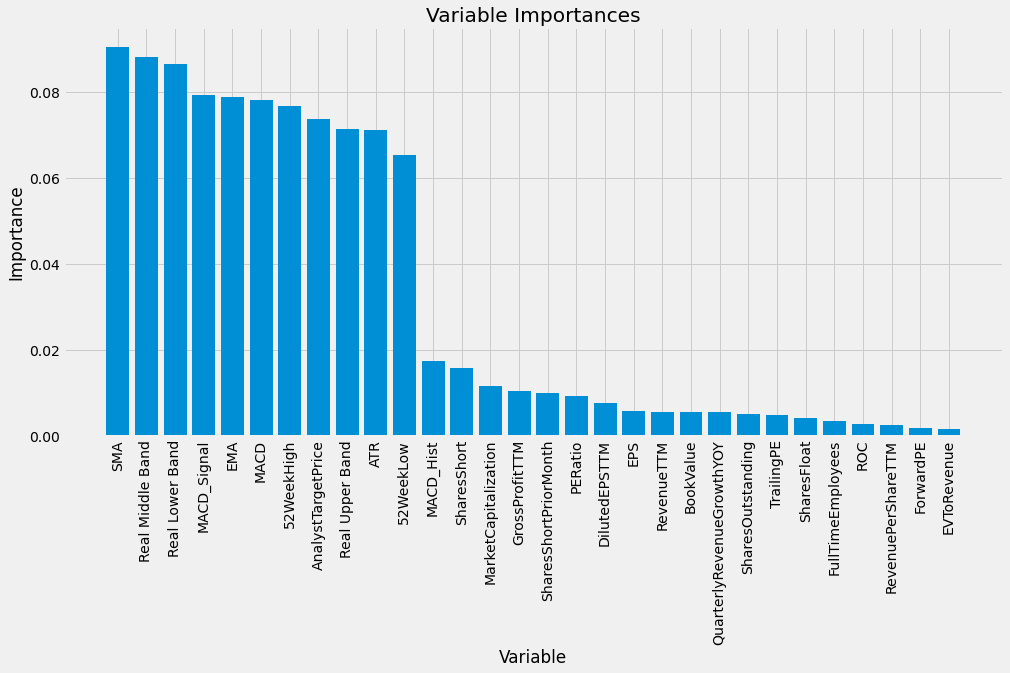

In [426]:
%matplotlib inline

# Set the style
plt.style.use('fivethirtyeight')

# list of x locations for plotting
x_values = list(range(len(sorted_x)))

# Make a bar chart
plt.bar(x_values, sorted_y, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, sorted_x, rotation='vertical')
  
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');
plt.gcf().set_size_inches(15, 7)

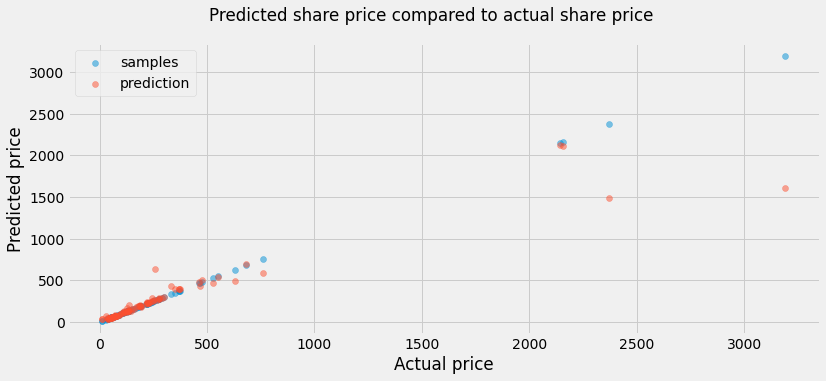

In [139]:
plt.scatter(pd.Series(y), pd.Series(y), label='samples', alpha=0.5)
plt.scatter(pd.Series(y), pd.Series(y_pred_rf), label='prediction', alpha=0.5)
plt.suptitle('Predicted share price compared to actual share price')
plt.ylabel('Predicted price')
plt.xlabel('Actual price')
plt.legend()
plt.gcf().set_size_inches(12, 5)

In [140]:
# Find mean absolute difference
errors = abs(y_pred_rf - y)
# Print out the mean absolute difference (mae)
print('Mean Absolute Difference:', round(np.mean(errors), 2), 'dollars.')

Mean Absolute Difference: 41.28 dollars.


In [141]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')
#print(errors)
#print(test_labels)
r2 = r2_score(y_true=y, y_pred=y_pred_rf)
# compute r2
print(f'R^2 score: {r2:.3}')

Accuracy: 88.17 %.
R^2 score: 0.846


In [142]:
results_df = full_df[['Symbol', '50DayMovingAverage']]
results_df['rf_pred'] = y_pred_rf
results_df['50DayMovingAverage'] = pd.to_numeric(results_df['50DayMovingAverage'])
results_df['rf_diff'] = results_df['rf_pred'] - results_df['50DayMovingAverage']
results_df['rf_diff_pct'] = results_df['rf_diff'] / results_df['50DayMovingAverage'] * 100
results_df

<ipython-input-142-8c957b686a84>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df['rf_pred'] = y_pred_rf
<ipython-input-142-8c957b686a84>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df['50DayMovingAverage'] = pd.to_numeric(results_df['50DayMovingAverage'])
<ipython-input-142-8c957b686a84>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

,Symbol,50DayMovingAverage,rf_pred,rf_diff,rf_diff_pct
0,ABBV,107.1074,113.397,6.2896,5.872237
1,ABT,120.1471,121.241,1.0939,0.910467
2,ACN,275.6562,272.749,-2.9072,-1.054647
3,ADBE,477.2415,499.007,21.7655,4.560689
4,AAPL,126.0871,166.528,40.4409,32.073781
...,...,...,...,...,...
96,WBA,53.2956,53.605,0.3094,0.580536
97,WFC,40.2994,37.551,-2.7484,-6.819953
98,WMT,136.1124,205.002,68.8896,50.612288
99,XOM,57.3168,53.677,-3.6398,-6.350320


In [143]:
# Most overvalued
results_df.sort_values('rf_diff_pct')[0:20]

,Symbol,50DayMovingAverage,rf_pred,rf_diff,rf_diff_pct
8,AMZN,3191.7227,1601.533,-1590.1897,-49.822301
15,BKNG,2371.7659,1484.906,-886.8599,-37.392388
16,BLK,762.7521,585.090,-177.6621,-23.292247
20,CHTR,630.3635,494.498,-135.8655,-21.553516
70,NFLX,527.0891,466.809,-60.2801,-11.436416
10,AXP,145.1462,128.968,-16.1782,-11.146141
22,CMCSA,55.2712,50.212,-5.0592,-9.153411
12,BAC,38.5288,35.186,-3.3428,-8.676107
9,AVGO,468.1641,433.732,-34.4321,-7.354707
97,WFC,40.2994,37.551,-2.7484,-6.819953


In [144]:
# Most undervalued
results_df.sort_values('rf_diff_pct', ascending=False)[0:20]

,Symbol,50DayMovingAverage,rf_pred,rf_diff,rf_diff_pct
37,F,12.4403,30.865,18.4247,148.104949
100,BRK-B,260.7103,638.036,377.3257,144.729878
41,GE,13.2771,31.820,18.5429,139.660769
84,T,30.1659,70.158,39.9921,132.573867
98,WMT,136.1124,205.002,68.8896,50.612288
4,AAPL,126.0871,166.528,40.4409,32.073781
46,GS,334.9400,434.247,99.3070,29.649191
28,CVS,74.4700,89.381,14.9110,20.022828
68,MSFT,244.1829,286.912,42.7291,17.498809
75,PFE,36.4388,42.767,6.3282,17.366653


In [145]:
results_df.sort_values('rf_pred', ascending=False)[0:20]

,Symbol,50DayMovingAverage,rf_pred,rf_diff,rf_diff_pct
45,GOOGL,2142.5476,2121.549,-20.9986,-0.980076
44,GOOG,2154.9310,2109.646,-45.2850,-2.101459
8,AMZN,3191.7227,1601.533,-1590.1897,-49.822301
15,BKNG,2371.7659,1484.906,-886.8599,-37.392388
88,TSLA,682.5647,701.713,19.1483,2.805346
100,BRK-B,260.7103,638.036,377.3257,144.729878
16,BLK,762.7521,585.090,-177.6621,-23.292247
72,NVDA,552.9547,545.544,-7.4107,-1.340200
3,ADBE,477.2415,499.007,21.7655,4.560689
20,CHTR,630.3635,494.498,-135.8655,-21.553516


# Input stocks for prediction

In [263]:
def get_predicted_worth(df, ticker, csv=None):
    cmp_all = pd.DataFrame()
    if csv is not None:
        cmp_all = pd.read_csv(csv).drop('Unnamed: 0', axis=1)
    else:
        try:
            cmp_all = pd.read_csv(f'{ticker}_rf_data.csv').drop('Unnamed: 0', axis=1)
        except:
            cmp_info = create_company_table([ticker])
            indicators = ['SMA', 'EMA', 'MACD', 'STOCH', 'RSI', 'CCI', 'AROON', 'BBANDS', 'ADX', 'OBV', 'ATR', 'ROC']

            cmp_ti = avg_tech_ind(get_tech_ind(ticker, indicators))
            series = pd.Series(cmp_ti)
            series['Symbol'] = ticker

            cmp_all = pd.merge(cmp_info, pd.DataFrame(series).T.sort_index(axis=1), on='Symbol')
            cmp_all.to_csv(f'{ticker}_rf_data.csv')

    model_input, features = clean_rf_data(cmp_all)
    prediction = rf.predict(model_input)

    fifty_day_ma = float(cmp_all.loc[:, '50DayMovingAverage'].values[0])
    rf_diff = float(prediction[0]) - fifty_day_ma
    rf_diff_pct = rf_diff / fifty_day_ma * 100

    series = pd.Series({'Symbol': ticker, '50DayMovingAverage': fifty_day_ma, 'rf_pred': prediction[0],
            'rf_diff': rf_diff, 'rf_diff_pct': rf_diff_pct})
    df = df.append(pd.DataFrame(series).T)
    
    return df, prediction, model_input

In [264]:
new_df = results_df

In [268]:
df, pred, model_input = get_predicted_worth(new_df, 'NVDA')

(1, 59)
(1,)


In [269]:
rf.predict(model_input)

array([497.442])

In [218]:
bool_series = new_df['Symbol'] == 'AAL'
new_df.loc[bool_series, :]

,Symbol,50DayMovingAverage,rf_pred,rf_diff,rf_diff_pct


In [361]:
def get_ticker_price(ticker, day=datetime.date.today()-timedelta(days=1)):
    time.sleep(12)
    print(ticker)
    day = day.strftime('%Y-%m-%d')
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={ticker}&apikey={av_api_key}'
    ts_dict = json.loads(requests.get(url).text)
    close = float(ts_dict['Time Series (Daily)'][day]['4. close'])
    return close

In [312]:
x = get_ticker_price('IBM')

In [362]:
results_change = results_df.copy()
results_change

,Symbol,50DayMovingAverage,rf_pred,rf_diff,rf_diff_pct
0,ABBV,107.1074,113.397,6.2896,5.872237
1,ABT,120.1471,121.241,1.0939,0.910467
2,ACN,275.6562,272.749,-2.9072,-1.054647
3,ADBE,477.2415,499.007,21.7655,4.560689
4,AAPL,126.0871,166.528,40.4409,32.073781
...,...,...,...,...,...
96,WBA,53.2956,53.605,0.3094,0.580536
97,WFC,40.2994,37.551,-2.7484,-6.819953
98,WMT,136.1124,205.002,68.8896,50.612288
99,XOM,57.3168,53.677,-3.6398,-6.350320


In [ ]:
results_change['Last_Price'] = results_change.apply(lambda x : get_ticker_price(x['Symbol']), axis =1)
results_change

In [371]:
save = results_change

In [ ]:
url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=AXP&apikey={av_api_key}'
json.loads(requests.get(url).text)

In [428]:
results_change['Change'] = abs(results_change['50DayMovingAverage'] - results_change['Last_Price'])
results_change['Diff_from_pred'] = results_change['rf_pred'] - results_change['Last_Price']
results_change['Pct_diff_from_pred'] = results_change['Diff_from_pred'] / results_change['rf_pred']  * 100
results_change['Change_Pct'] = results_change['Change'] / results_change['50DayMovingAverage'] * 100

def compare(a, b):
    if a > b:
        return 1
    return 0

results_change['Predicted_to_increase?'] = results_change.apply(lambda x : compare(x['rf_pred'], x['50DayMovingAverage']), axis =1)
results_change['Increased?'] = results_change.apply(lambda x : compare(x['Last_Price'], x['50DayMovingAverage']), axis =1)
results_change

,Symbol,50DayMovingAverage,rf_pred,rf_diff,rf_diff_pct,Last_Price,Change,Change_Pct,Diff_from_pred,Pct_diff_from_pred,Predicted_to_increase?,Increased?
0,ABBV,107.1074,113.397,6.2896,5.872237,110.890,3.7826,3.531595,2.507,2.210817,1,1
1,ABT,120.1471,121.241,1.0939,0.910467,121.010,0.8629,0.718203,0.231,0.190530,1,1
2,ACN,275.6562,272.749,-2.9072,-1.054647,292.540,16.8838,6.124948,-19.791,-7.256122,0,1
3,ADBE,477.2415,499.007,21.7655,4.560689,516.090,38.8485,8.140218,-17.083,-3.423399,1,1
4,AAPL,126.0871,166.528,40.4409,32.073781,133.480,7.3929,5.863328,33.048,19.845311,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
96,WBA,53.2956,53.605,0.3094,0.580536,52.735,0.5606,1.051869,0.870,1.622983,1,0
97,WFC,40.2994,37.551,-2.7484,-6.819953,46.240,5.9406,14.741162,-8.689,-23.139197,0,1
98,WMT,136.1124,205.002,68.8896,50.612288,139.630,3.5176,2.584335,65.372,31.888469,1,1
99,XOM,57.3168,53.677,-3.6398,-6.350320,58.940,1.6232,2.831979,-5.263,-9.804944,0,1


In [452]:
avg_change = round(np.mean(results_change["Change"]), 2)
avg_change_pct = round(np.mean(results_change["Change_Pct"]), 2)
avg_diff = round(np.mean(results_change["Diff_from_pred"]), 2)
avg_diff_pct = round(np.mean(results_change["Pct_diff_from_pred"]), 2)

num_pred_incr = np.sum(results_change["Predicted_to_increase?"])
num_pred_decr = results_change.shape[0] - num_pred_incr
pct_pred_incr = round(num_pred_incr / results_change.shape[0] * 100, 2)
pct_pred_decr = round(num_pred_decr / results_change.shape[0] * 100, 2)

num_act_incr = np.sum(results_change["Increased?"])
num_act_decr = results_change.shape[0] - num_act_incr
pct_act_incr = round(min(num_act_incr, num_pred_incr) / max(num_act_incr, num_pred_incr) * 100, 2)
pct_act_decr = round(min(num_act_decr, num_pred_decr) / max(num_act_decr, num_pred_decr) * 100, 2)

print(f'Avg Change: {avg_change}')
print(f'Avg % Change: {avg_change_pct}%')
print(f'Avg Diff from Pred: {avg_diff}')
print(f'Avg % Diff from Pred: {avg_diff_pct}%')

print(f'Num Predicted to Increase: {num_pred_incr}')
print(f'Num Actually Increased: {num_act_incr}')
print(f'Num Predicted to Decrease: {num_pred_decr}')
print(f'Num Actually Decreased: {num_act_decr}')

print(f'% Predicted to Increase: {pct_pred_incr}%')
#print(f'% Correctly Predicted to Increase: {pct_act_incr}%')
print(f'% Predicted to Decrease: {pct_pred_decr}%')
#print(f'% Correctly Predicted to Decrease: {pct_act_decr}%')

bool_series = results_change["Predicted_to_increase?"] == 1
bool_series2 = results_change["Increased?"] == 0
num_wrong_incr = len(results_change.loc[bool_series,:].loc[bool_series2,:])
pct_wrong_incr = round(num_wrong_incr / num_pred_incr * 100, 2)

bool_series3 = results_change["Predicted_to_increase?"] == 0
bool_series4 = results_change["Increased?"] == 1
num_wrong_decr = len(results_change.loc[bool_series3,:].loc[bool_series4,:])
pct_wrong_decr = round(num_wrong_decr / num_pred_decr * 100, 2)

print(f'% Predicted to Increase but Decreased: {num_wrong_incr}')
print(f'% Correctly Predicted to Increase: {100 - pct_wrong_incr}%')
print(f'% Incorrectly Predicted to Increase: {pct_wrong_incr}%')

print(f'% Predicted to Decrease but Increase: {num_wrong_decr}')
print(f'% Correctly Predicted to Decrease: {100 - pct_wrong_decr}%')
print(f'% Incorrectly Predicted to Decrease: {pct_wrong_decr}%')

accuracy = round((num_wrong_incr + num_wrong_decr) / results_change.shape[0] * 100, 2)

print(f'Accuracy: {accuracy}')

Avg Change: 18.0
Avg % Change: 4.94%
Avg Diff from Pred: -35.98
Avg % Diff from Pred: -2.29%
Num Predicted to Increase: 56
Num Actually Increased: 79
Num Predicted to Decrease: 45
Num Actually Decreased: 22
% Predicted to Increase: 55.45%
% Predicted to Decrease: 44.55%
% Predicted to Increase but Decreased: 12
% Correctly Predicted to Increase: 78.57%
% Incorrectly Predicted to Increase: 21.43%
% Predicted to Decrease but Increase: 35
% Correctly Predicted to Decrease: 22.22%
% Incorrectly Predicted to Decrease: 77.78%
Accuracy: 46.53


In [430]:
# Closest predictions
results_change.reindex(results_change.Pct_diff_from_pred.abs().sort_values().index)[0:20]

,Symbol,50DayMovingAverage,rf_pred,rf_diff,rf_diff_pct,Last_Price,Change,Change_Pct,Diff_from_pred,Pct_diff_from_pred,Predicted_to_increase?,Increased?
58,LOW,188.2306,198.516,10.2854,5.464255,198.440,10.2094,5.423879,0.076,0.038284,1,1
1,ABT,120.1471,121.241,1.0939,0.910467,121.010,0.8629,0.718203,0.231,0.190530,1,1
30,DD,76.8324,78.186,1.3536,1.761757,77.920,1.0876,1.415549,0.266,0.340214,1,1
40,GD,180.4074,191.563,11.1556,6.183560,190.710,10.3026,5.710741,0.853,0.445284,1,1
94,V,219.5591,235.800,16.2409,7.397052,236.860,17.3009,7.879837,-1.060,-0.449534,1,1
69,NEE,75.9229,76.727,0.8041,1.059101,77.220,1.2971,1.708444,-0.493,-0.642538,1,1
48,HON,219.2809,222.465,3.1841,1.452064,223.900,4.6191,2.106476,-1.435,-0.645045,1,1
90,UNH,371.3321,397.908,26.5759,7.156909,401.550,30.2179,8.137702,-3.642,-0.915287,1,1
43,GM,58.0144,57.209,-0.8054,-1.388276,56.570,1.4444,2.489727,0.639,1.116957,0,0
76,PG,133.2568,134.018,0.7612,0.571228,132.510,0.7468,0.560422,1.508,1.125222,1,0


In [ ]:
# Most overvalued
results_df.sort_values('Change')[0:20]

In [ ]:
# Most undervalued
results_df.sort_values('Change_Pct', ascending=False)[0:20]

In [431]:
snp100

,Symbol,200DayMovingAverage,50DayMovingAverage,52WeekHigh,52WeekLow,AnalystTargetPrice,AssetType,Beta,BookValue,CIK,...,MACD_Signal,OBV,ROC,RSI,Real Lower Band,Real Middle Band,Real Upper Band,SMA,SlowD,SlowK
0,ABBV,102.6966,107.1074,112.0400,76.6222,122.17,Common Stock,0.8064,7.408,1551152,...,0.169436,1.345127e+09,2.398564,64.103314,116.798500,120.584243,124.369979,120.584243,78.637343,77.905593
1,ABT,114.7039,120.1471,128.0698,84.8867,135.84,Common Stock,0.7016,18.509,1800,...,0.457164,2.074995e+09,2.411214,63.356800,133.977071,137.454650,140.932236,137.454650,61.740750,61.174693
2,ACN,254.1688,275.6562,293.2800,172.4964,298.83,Common Stock,1.1004,28.802,1467373,...,6.763621,9.790890e+08,6.595664,81.186421,306.730843,318.534886,330.338929,318.534886,89.770657,89.605029
3,ADBE,478.6173,477.2415,536.8800,335.4400,571.99,Common Stock,0.9482,28.28,796343,...,9.380529,6.995659e+08,11.723271,76.990107,522.716771,558.291779,593.866793,558.291779,86.065436,83.476464
4,AAPL,125.4723,126.0871,144.8735,70.4266,152.06,Common Stock,1.2195,3.936,320193,...,0.452721,1.083284e+11,8.482886,69.236979,136.257636,144.497886,152.738114,144.497886,87.671071,87.520157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,WBA,45.4588,53.2956,57.0500,32.6577,54.06,Common Stock,0.4771,24.424,1618921,...,1.296621,5.914138e+07,1.373357,64.547257,58.924807,61.804236,64.683664,61.804236,48.622943,45.102693
97,WFC,32.0566,40.2994,44.6800,20.5999,47.47,Common Stock,1.3221,40.309,72971,...,1.098957,-1.465872e+09,7.169443,71.952821,43.544029,46.020007,48.495979,46.020007,84.541450,84.882414
98,WMT,142.1273,136.1124,152.4636,115.6237,159.38,Common Stock,0.4793,28.687,104169,...,0.940657,5.385776e+08,4.624629,70.842207,153.047600,157.400536,161.753457,157.400536,73.402457,71.182636
99,XOM,46.6310,57.3168,62.5500,29.8698,62.52,Common Stock,1.4137,37.125,34088,...,0.418829,-3.866141e+08,-1.936771,55.751893,62.911464,64.491321,66.071179,64.491321,48.853486,47.541571
